In [4]:
import plotly.express as px
from collections import Counter
import pandas as pd
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Data imported directly

In [8]:
def get_data_path(filepath=None):
    if filepath is None:
        filepath = "../data_path.txt"  
    try:
        with open(filepath, "r") as f:
            return f.readline().strip()
    except FileNotFoundError:
        raise FileNotFoundError(f"Die Datei '{filepath}' wurde nicht gefunden! Stelle sicher, dass sie existiert.")

data_dir = get_data_path()

data_counts = []

# Durchlaufe alle Unterordner
for root, dirs, files in os.walk(data_dir):
    if files:  # Falls Dateien im Ordner vorhanden sind
        dataset_type = os.path.basename(os.path.dirname(root))  # Train/Val/Test aus übergeordnetem Ordner
        class_name = os.path.basename(root)  # Klassenname
        file_count = len(files)
        data_counts.append({"Dataset": dataset_type, "Class": class_name, "count": file_count})

# In ein DataFrame umwandeln
df_counts = pd.DataFrame(data_counts)
print(df_counts)
print("=============================")
print(df_counts.groupby("Dataset").sum())

  Dataset        Class  count
0    test  Parasitized   1378
1    test   Uninfected   1378
2   train  Parasitized  11024
3   train   Uninfected  11024
4     val  Parasitized   1378
5     val   Uninfected   1378
                         Class  count
Dataset                              
test     ParasitizedUninfected   2756
train    ParasitizedUninfected  22048
val      ParasitizedUninfected   2756


# Data imported with data_loader

In [ ]:
# `data/`- Add directory to Python search path
data_path = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
sys.path.append(data_path)

import data_loader


Verwende Datenpfad: C:\ZHAW_local\semester_6_local\DS in Health\project_work\data
Datenverzeichnis: C:\ZHAW_local\semester_6_local\DS in Health\project_work\data


In [3]:
train_dataset = data_loader.train_dataset
val_dataset = data_loader.val_dataset
test_dataset = data_loader.test_dataset

print(f"Train: {len(train_dataset)}")
print(train_dataset)
print("===============================")
print(f"Validation: {len(val_dataset)}")
print(val_dataset)
print("===============================")
print(f"Test: {len(test_dataset)}")
print(test_dataset)

Train: 22048
Dataset ImageFolder
    Number of datapoints: 22048
    Root location: C:\ZHAW_local\semester_6_local\DS in Health\project_work\data\train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Validation: 2755
Dataset ImageFolder
    Number of datapoints: 2755
    Root location: C:\ZHAW_local\semester_6_local\DS in Health\project_work\data\val
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Test: 2755
Dataset ImageFolder
    Number of datapoints: 2755
    Root location: C:\ZHAW_local\semester_6_local\DS in Health\project_work\data\test
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bi

# label distribution

In [18]:
# Funktion zur Berechnung der Label-Verteilung
def get_label_counts(dataset, dataset_name):
    label_counts = Counter([label for _, label in dataset])
    return pd.DataFrame({
        "class": [dataset.classes[i] for i in label_counts.keys()],
        "count": list(label_counts.values()),
        "dataset": dataset_name
    })

# Dataframes für Train, Val, Test erstellen
df_train = get_label_counts(train_dataset, "Train dataset")
df_val = get_label_counts(val_dataset, "Validation dataset")
df_test = get_label_counts(test_dataset, "Test dataset")

# Alle DataFrames zusammenführen
df = pd.concat([df_train, df_val, df_test], ignore_index=True)

# Plot mit Plotly erstellen
fig = px.bar(df, x="class", y="count", color="dataset", barmode="group",
             title="Distribution of classes Train, Val und Test",
             labels={"count": "Number of Pictures", "class": "class", "dataset": "dataset"})

fig.show()


# Sample images

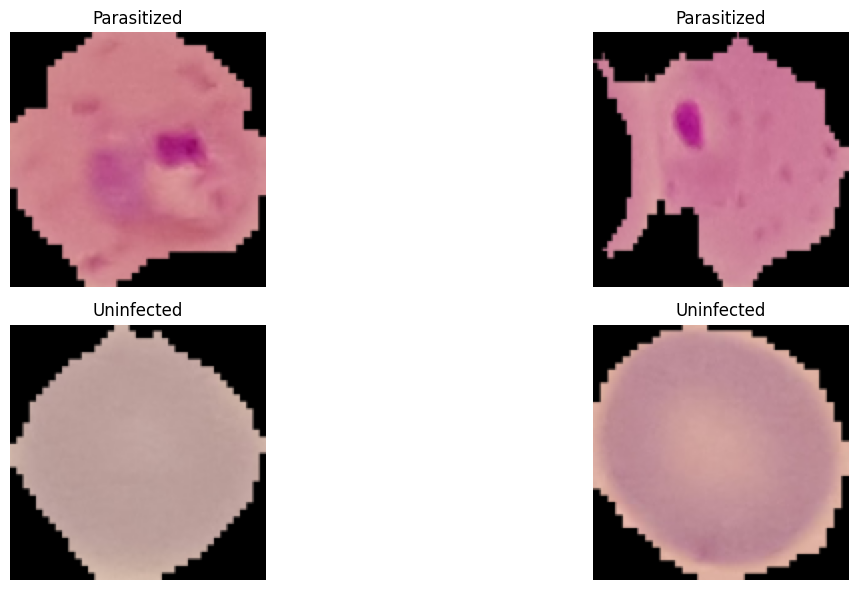

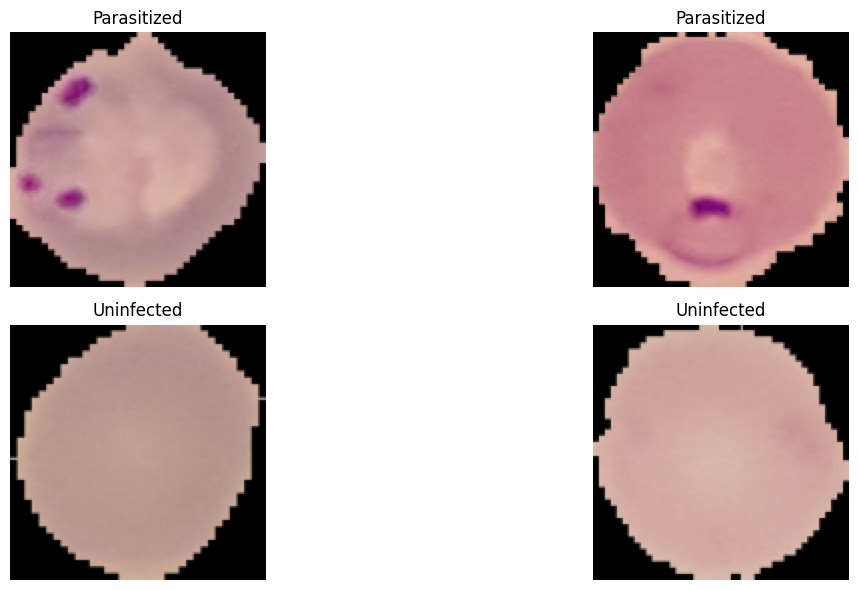

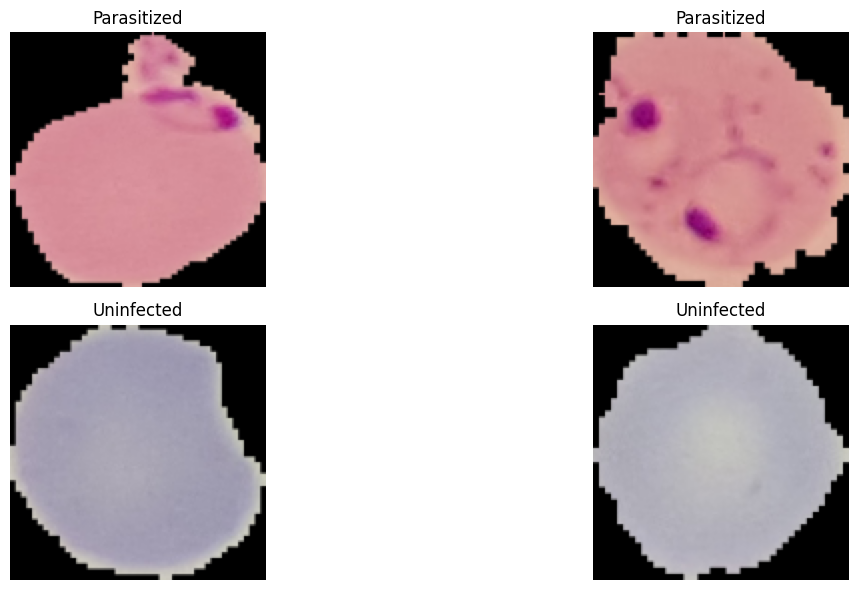

In [ ]:
def show_images_per_class(dataset, num_images=5):
    """
    shows `num_images` pictures per class.
    """
    class_indices = defaultdict(list)
    
    # Sammle alle Indizes für jede Klasse
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    num_classes = len(dataset.classes)
    fig, axes = plt.subplots(num_classes, num_images, figsize=(15, num_classes * 3))

    for class_id, indices in class_indices.items():
        selected_indices = np.random.choice(indices, min(num_images, len(indices)), replace=False)
        
        for i, img_idx in enumerate(selected_indices):
            img, label = dataset[img_idx]
            img = img.permute(1, 2, 0).numpy()  # Umwandlung für die Anzeige
            img = (img * 0.5) + 0.5  # Rück-Normalisierung
            
            ax = axes[class_id, i] if num_classes > 1 else axes[i]
            ax.imshow(img)
            ax.set_title(dataset.classes[label])
            ax.axis("off")

    plt.tight_layout()
    plt.show()

print("Sample images per class training dataset:")
show_images_per_class(train_dataset, num_images=2)

print("Sample images per class validation dataset:")
show_images_per_class(val_dataset, num_images=2)

print("Sample images per class test dataset:")
show_images_per_class(test_dataset, num_images=2)
